### Imports and version checks

In [1]:
import torch
import pyg_lib

print("PyTorch Version:", torch.__version__)
print("pyg-lib Version:", pyg_lib.__version__)


PyTorch Version: 2.6.0
pyg-lib Version: 0.4.0


### Uncomment this if you want to install packages

In [2]:
# # # Install required packages.
# !pip install torch==2.6.0
# !pip install torch-geometric torch-sparse torch-scatter torch-cluster torch-spline-conv pyg-lib -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install pytorch_frame
# !pip install -U sentence-transformers # we need another package for text encoding


#### Major Imports

In [3]:
import os
import math
import numpy as np
from tqdm import tqdm

import torch
import torch_geometric
import torch_frame

from torch.nn import BCEWithLogitsLoss, L1Loss
from relbench.datasets import get_dataset
from relbench.tasks import get_task

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

#### Load data set - `rel-f1` and the task - `driver position`

In [4]:
dataset = get_dataset("rel-f1", download=True)
task = get_task("rel-f1", "driver-position", download=True)

train_table = task.get_table("train")
val_table = task.get_table("val")
test_table = task.get_table("test")

out_channels = 1
loss_fn = L1Loss()
tune_metric = "rmse"
higher_is_better = False

Let's check out the training table just to make sure it looks fine.

In [5]:
train_table

Table(df=
           date  driverId  position
0    2004-07-05        10     10.75
1    2004-07-05        47     12.00
2    2004-03-07         7     15.00
3    2004-01-07        10      9.00
4    2003-09-09        52     13.00
...         ...       ...       ...
7448 1995-08-22        96     15.75
7449 1975-06-08       228      8.00
7450 1965-05-31       418     16.00
7451 1961-08-20       467     37.00
7452 1954-05-29       677     30.00

[7453 rows x 3 columns],
  fkey_col_to_pkey_table={'driverId': 'drivers'},
  pkey_col=None,
  time_col=date)

#### setting device information and directory

In [6]:
# Some book keeping
from torch_geometric.seed import seed_everything

seed_everything(42)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # check that it's cuda if you want it to run in reasonable time!
root_dir = ".tutorials/data"

cpu


#### Getting database and column type dictionary

In [7]:
from relbench.modeling.utils import get_stype_proposal

db = dataset.get_db()
col_to_stype_dict = get_stype_proposal(db)
col_to_stype_dict

Loading Database object from /Users/adarshjohny/Library/Caches/relbench/rel-f1/db...
Done in 0.01 seconds.


{'qualifying': {'qualifyId': <stype.numerical: 'numerical'>,
  'raceId': <stype.numerical: 'numerical'>,
  'driverId': <stype.numerical: 'numerical'>,
  'constructorId': <stype.numerical: 'numerical'>,
  'number': <stype.numerical: 'numerical'>,
  'position': <stype.numerical: 'numerical'>,
  'date': <stype.timestamp: 'timestamp'>},
 'drivers': {'driverId': <stype.numerical: 'numerical'>,
  'driverRef': <stype.text_embedded: 'text_embedded'>,
  'code': <stype.text_embedded: 'text_embedded'>,
  'forename': <stype.text_embedded: 'text_embedded'>,
  'surname': <stype.text_embedded: 'text_embedded'>,
  'dob': <stype.timestamp: 'timestamp'>,
  'nationality': <stype.text_embedded: 'text_embedded'>},
 'results': {'resultId': <stype.numerical: 'numerical'>,
  'raceId': <stype.numerical: 'numerical'>,
  'driverId': <stype.numerical: 'numerical'>,
  'constructorId': <stype.numerical: 'numerical'>,
  'number': <stype.numerical: 'numerical'>,
  'grid': <stype.numerical: 'numerical'>,
  'position':

Implementing a GloVe-based text embedding model using SentenceTransformer to convert sentences into numerical tensor representations for RelBench training.

In [8]:
from typing import List, Optional
from sentence_transformers import SentenceTransformer
from torch import Tensor


class GloveTextEmbedding:
    def __init__(self, device: Optional[torch.device
                                            ] = None):
        self.model = SentenceTransformer(
            "sentence-transformers/average_word_embeddings_glove.6B.300d",
            device=device if torch.cuda.is_available() else "cpu"
        )

    def __call__(self, sentences: List[str]) -> Tensor:
        return torch.from_numpy(self.model.encode(sentences))

Implementing a caching mechanism to either load precomputed RelBench snapshot graph data or generate it using GloVe-based text embeddings and save for future use.

In [9]:
import os
import pickle

output_file = 'output_fi.pkl'
cached = True

if os.path.exists(output_file) and cached:
    # File exists: load the data
    with open(output_file, 'rb') as f:
        data, col_stats_dict = pickle.load(f)
    print("Loaded data from file.")
else:
    # File does not exist: run the code and save the output
    from torch_frame.config.text_embedder import TextEmbedderConfig
    from relbench.modeling.graph import make_snapshot_graph
    # Ensure GloveTextEmbedding, device, db, col_to_stype_dict, and root_dir are defined
    text_embedder_cfg = TextEmbedderConfig(
        text_embedder=GloveTextEmbedding(device=device), batch_size=256
    )
    
    data, col_stats_dict = make_snapshot_graph(
        db,
        col_to_stype_dict=col_to_stype_dict,              # specified column types
        main_table_name="races",                          # use 'races' table as timestamp reference
        interval_days=1461,                                 # generate snapshots every 30 days
        text_embedder_cfg=text_embedder_cfg,              # chosen text encoder
        cache_dir=os.path.join(root_dir, "rel-f1_materialized_cache"),  # store materialized graph for convenience
    )
    
    # Save the output to a file for future use
    with open(output_file, 'wb') as f:
        pickle.dump((data, col_stats_dict), f)
    print("Data computed and saved to file.")


Loaded data from file.


## Checking various objects and rendering a graph

Visualizing a subset of a heterogeneous graph by extracting edges of a selected type, converting it to a NetworkX graph, and plotting a sampled subgraph for better interpretability.


Using edge type: ('results', 'f2p_raceId', 'races')


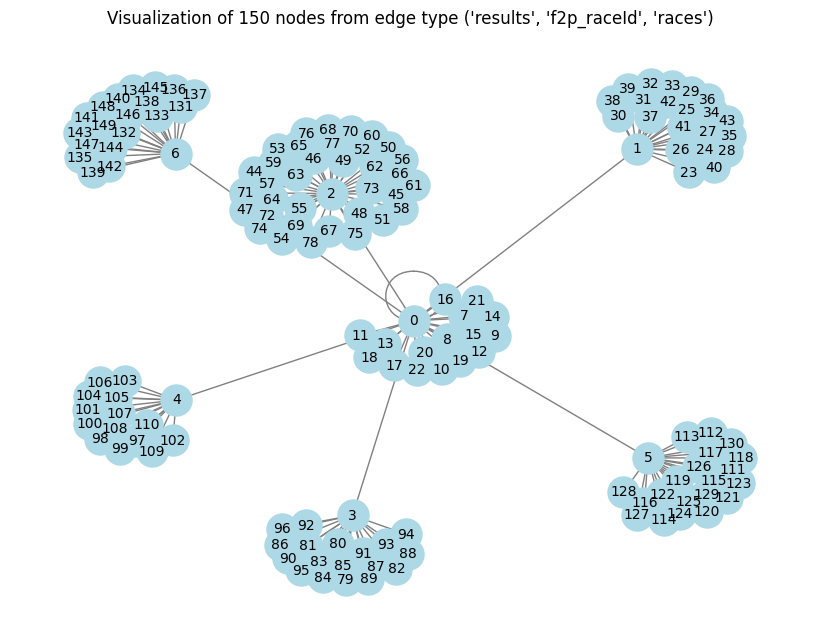

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_hetero_graph(snapshot, num_nodes=10):
    """Visualize a small portion of a heterogeneous graph with a specific edge type."""
    
    # Select the first available edge type (e.g., ('node_type1', 'relation', 'node_type2'))
    edge_type = list(snapshot.edge_index_dict.keys())[0]
    print(f"Using edge type: {edge_type}")  # Debugging

    # Extract edge index for the selected edge type
    edge_index = snapshot[edge_type].edge_index
    
    # Convert the selected subgraph to NetworkX
    nx_graph = nx.Graph()  # Create an empty NetworkX graph

    # Add edges from edge_index
    for i in range(edge_index.shape[1]):
        src = int(edge_index[0, i].item())
        dst = int(edge_index[1, i].item())
        if edge_index.numel() == 0:
            print(f"⚠️ Warning: Edge type {edge_type} has no edges! Skipping visualization.")
            return
        nx_graph.add_edge(src, dst)  # Add edge to the NetworkX graph

    # Get a subset of nodes
    sampled_nodes = list(nx_graph.nodes)[:num_nodes]
    subgraph = nx_graph.subgraph(sampled_nodes)
    
    # Plot the graph
    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(f"Visualization of {num_nodes} nodes from edge type {edge_type}")
    plt.show()

# Select the first snapshot
snapshot = data[5]  # Assuming data is a list of snapshots

# Call the function
visualize_hetero_graph(snapshot, num_nodes=150)


We can now check out `data`, our main graph object. `data` is a heterogeneous and temporal graph, with node types given by the table it originates from.

In [11]:
data[0]

HeteroData(
  results={
    tf=TensorFrame([23, 15]),
    time=[23],
    x=[20323, 128],
    num_nodes=20323,
  },
  standings={
    tf=TensorFrame([23, 7]),
    time=[23],
    x=[28115, 128],
    num_nodes=28115,
  },
  races={
    tf=TensorFrame([1, 7]),
    time=[1],
    x=[820, 128],
    num_nodes=820,
  },
  drivers={
    tf=TensorFrame([857, 7]),
    x=[857, 128],
  },
  constructors={
    tf=TensorFrame([211, 4]),
    x=[211, 128],
  },
  circuits={
    tf=TensorFrame([77, 8]),
    x=[77, 128],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 23],
    edge_time=[23],
  },
  (results, f2p_driverId, drivers)={
    edge_index=[2, 20323],
    edge_time=[20323],
  },
  (results, f2p_constructorId, constructors)={
    edge_index=[2, 20323],
    edge_time=[20323],
  },
  (standings, f2p_raceId, races)={
    edge_index=[2, 23],
    edge_time=[23],
  },
  (standings, f2p_driverId, drivers)={
    edge_index=[2, 28115],
    edge_time=[28115],
  },
  (races, f2p_circuitId, circuits)

We can also check out the TensorFrame for one table like this:

In [12]:
col_stats_dict

{'results': {'resultId': {<StatType.MEAN: 'MEAN'>: 9477.0,
   <StatType.STD: 'STD'>: 5471.837168629929,
   <StatType.QUANTILES: 'QUANTILES'>: [0.0, 4738.5, 9477.0, 14215.5, 18954.0]},
  'raceId': {<StatType.MEAN: 'MEAN'>: 376.2403587443946,
   <StatType.STD: 'STD'>: 207.82480738161536,
   <StatType.QUANTILES: 'QUANTILES'>: [0.0, 210.0, 382.0, 540.0, 754.0]},
  'driverId': {<StatType.MEAN: 'MEAN'>: 208.42891057768398,
   <StatType.STD: 'STD'>: 171.6331562667825,
   <StatType.QUANTILES: 'QUANTILES'>: [1.0, 83.0, 165.0, 292.0, 806.0]},
  'constructorId': {<StatType.MEAN: 'MEAN'>: 44.85222896333421,
   <StatType.STD: 'STD'>: 49.9110425186994,
   <StatType.QUANTILES: 'QUANTILES'>: [0.0, 14.0, 26.0, 55.0, 201.0]},
  'number': {<StatType.MEAN: 'MEAN'>: 17.013193308354,
   <StatType.STD: 'STD'>: 12.862783345840114,
   <StatType.QUANTILES: 'QUANTILES'>: [0.0, 7.0, 16.0, 24.0, 208.0]},
  'grid': {<StatType.MEAN: 'MEAN'>: 11.23292007385914,
   <StatType.STD: 'STD'>: 7.567596228743521,
   <StatTyp

In [13]:
print(len(data))  # Number of snapshots created


15


In [14]:
data[0]["races"].tf[10:20]

TensorFrame(
  num_cols=7,
  num_rows=0,
  numerical (3): ['circuitId', 'raceId', 'round'],
  categorical (1): ['year'],
  timestamp (2): ['date', 'time'],
  embedding (1): ['name'],
  has_target=False,
  device='cpu',
)

In [15]:
data.__sizeof__()

168

#### Edge types

In [16]:
for edge_type in data[0].edge_types:
    print(f"Edge: {edge_type}, Shape: {data[0][edge_type].edge_index.shape}")


Edge: ('results', 'f2p_raceId', 'races'), Shape: torch.Size([2, 23])
Edge: ('results', 'f2p_driverId', 'drivers'), Shape: torch.Size([2, 20323])
Edge: ('results', 'f2p_constructorId', 'constructors'), Shape: torch.Size([2, 20323])
Edge: ('standings', 'f2p_raceId', 'races'), Shape: torch.Size([2, 23])
Edge: ('standings', 'f2p_driverId', 'drivers'), Shape: torch.Size([2, 28115])
Edge: ('races', 'f2p_circuitId', 'circuits'), Shape: torch.Size([2, 820])


#### Node Types

In [17]:
for node_type in data[0].node_types:
    print(f"Node: {node_type}, Feature Shape: {data[0][node_type].tf}")


Node: results, Feature Shape: TensorFrame(
  num_cols=15,
  num_rows=23,
  numerical (14): ['constructorId', 'driverId', 'fastestLap', 'grid', 'laps', 'milliseconds', 'number', 'points', 'position', 'positionOrder', 'raceId', 'rank', 'resultId', 'statusId'],
  timestamp (1): ['date'],
  has_target=False,
  device='cpu',
)
Node: standings, Feature Shape: TensorFrame(
  num_cols=7,
  num_rows=23,
  numerical (6): ['driverId', 'driverStandingsId', 'points', 'position', 'raceId', 'wins'],
  timestamp (1): ['date'],
  has_target=False,
  device='cpu',
)
Node: races, Feature Shape: TensorFrame(
  num_cols=7,
  num_rows=1,
  numerical (3): ['circuitId', 'raceId', 'round'],
  categorical (1): ['year'],
  timestamp (2): ['date', 'time'],
  embedding (1): ['name'],
  has_target=False,
  device='cpu',
)
Node: drivers, Feature Shape: TensorFrame(
  num_cols=7,
  num_rows=857,
  numerical (1): ['driverId'],
  timestamp (1): ['dob'],
  embedding (5): ['code', 'driverRef', 'forename', 'nationality', 

In [18]:
data[0][("races", "f2p_circuitId", "circuits")]

{'edge_index': tensor([[  0,   1,   2,  ..., 817, 818, 819],
        [  8,   5,  18,  ...,  21,  17,  23]]), 'edge_time': tensor([-6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
        -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08, -6.1975e+08,
  

This code sets up NeighborLoader for node classification or link prediction tasks on a temporal, heterogeneous graph from RelBench. It loads nodes related to drivers for training, validation, and testing across multiple time-based snapshots.

In [19]:
from relbench.modeling.graph import get_node_train_table_input
from torch_geometric.loader import NeighborLoader
import torch

loader_dict = {}
for split, table in [("train", train_table), ("val", val_table), ("test", test_table)]:
    table_input = get_node_train_table_input(table=table, task=task)
    entity_table = table_input.nodes[0]  # 'drivers'
    loader_dict[split] = []

    # Get driverIds from the table
    driver_ids = torch.tensor(table.df['driverId'].values, dtype=torch.long)

    for snapshot_idx, snapshot in enumerate(data):
        time_attr = "time" if table_input.time is not None and "time" in snapshot.get(entity_table, {}) else None
        if time_attr is None and 'dob' in snapshot.get(entity_table, {}):
            time_attr = 'dob'

        if snapshot[entity_table].num_nodes is None or snapshot[entity_table].num_nodes == 0:
            print(f"⚠️ No nodes for {entity_table}. Skipping snapshot {snapshot_idx}.")
            continue
        print(f"Available node types in snapshot {snapshot_idx}: {snapshot.node_types}")
        if entity_table not in snapshot.node_types:
            print(f"---{entity_table} not found in snapshot {snapshot_idx}. Skipping.")
            continue

        # Map driverIds to snapshot node indices (assuming 'n_id' or similar exists)
        if 'n_id' not in snapshot[entity_table]:
            print(f"---- 'n_id' not found in {entity_table} for snapshot {snapshot_idx}. Assuming sequential IDs.")
            snapshot[entity_table].n_id = torch.arange(snapshot[entity_table].num_nodes)
        
        # Find indices of driverIds in the snapshot
        snapshot_driver_ids = snapshot[entity_table].n_id
        mask = torch.isin(snapshot_driver_ids, driver_ids)
        input_node_indices = snapshot_driver_ids[mask]

        if len(input_node_indices) == 0:
            print(f"⚠️ No matching {entity_table} nodes in snapshot {snapshot_idx} for {split} table.")
            continue

        loader = NeighborLoader(
            snapshot,
            num_neighbors=[10, 10],
            time_attr=time_attr,
            input_nodes=(entity_table, input_node_indices),  # Restrict to matching nodes
            input_time=table_input.time if time_attr is not None else None,
            transform=table_input.transform,
            batch_size=512,
            temporal_strategy="uniform",
            shuffle=(split == "train"),
            num_workers=4,
            persistent_workers=False,
        )
        if not any(loader):
            print(f"⚠️ Loader for {entity_table} in snapshot {snapshot_idx} is empty!")
        else:
            print(f"Loader for snapshot {snapshot_idx} created with {len(input_node_indices)} input nodes.")
        loader_dict[split].append(loader)

# Debug loaders
for split in ["train", "val", "test"]:
    print(f"\nChecking {split} loaders:")
    for i, snapshot_loader in enumerate(loader_dict[split]):
        print(f"  Snapshot {i}:")
        batches = list(snapshot_loader)
        print(f"    Number of batches: {len(batches)}")
        for j, batch in enumerate(batches[:2]):  # Limit to first 2 batches
            print(f"    Batch {j}: {batch}")

Available node types in snapshot 0: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 0. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 0 created with 771 input nodes.
Available node types in snapshot 1: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 1. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 1 created with 771 input nodes.
Available node types in snapshot 2: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 2. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 2 created with 771 input nodes.
Available node types in snapshot 3: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 3. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 3 created with 771 input nodes.
Available node types in snapshot 4: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 4. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 4 created with 771 input nodes.
Available node types in snapshot 5: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 5. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 5 created with 771 input nodes.
Available node types in snapshot 6: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 6. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 6 created with 771 input nodes.
Available node types in snapshot 7: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 7. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 7 created with 771 input nodes.
Available node types in snapshot 8: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 8. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 8 created with 771 input nodes.
Available node types in snapshot 9: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 9. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 9 created with 771 input nodes.
Available node types in snapshot 10: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 10. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 10 created with 771 input nodes.
Available node types in snapshot 11: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 11. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 11 created with 771 input nodes.
Available node types in snapshot 12: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 12. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 12 created with 771 input nodes.
Available node types in snapshot 13: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 13. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 13 created with 771 input nodes.
Available node types in snapshot 14: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
---- 'n_id' not found in drivers for snapshot 14. Assuming sequential IDs.


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 14 created with 771 input nodes.
Available node types in snapshot 0: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 0 created with 47 input nodes.
Available node types in snapshot 1: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 1 created with 47 input nodes.
Available node types in snapshot 2: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 2 created with 47 input nodes.
Available node types in snapshot 3: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 3 created with 47 input nodes.
Available node types in snapshot 4: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 4 created with 47 input nodes.
Available node types in snapshot 5: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 5 created with 47 input nodes.
Available node types in snapshot 6: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 6 created with 47 input nodes.
Available node types in snapshot 7: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 7 created with 47 input nodes.
Available node types in snapshot 8: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 8 created with 47 input nodes.
Available node types in snapshot 9: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 9 created with 47 input nodes.
Available node types in snapshot 10: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 10 created with 47 input nodes.
Available node types in snapshot 11: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 11 created with 47 input nodes.
Available node types in snapshot 12: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 12 created with 47 input nodes.
Available node types in snapshot 13: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 13 created with 47 input nodes.
Available node types in snapshot 14: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 14 created with 47 input nodes.
Available node types in snapshot 0: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 0 created with 56 input nodes.
Available node types in snapshot 1: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 1 created with 56 input nodes.
Available node types in snapshot 2: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 2 created with 56 input nodes.
Available node types in snapshot 3: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 3 created with 56 input nodes.
Available node types in snapshot 4: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 4 created with 56 input nodes.
Available node types in snapshot 5: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 5 created with 56 input nodes.
Available node types in snapshot 6: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 6 created with 56 input nodes.
Available node types in snapshot 7: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 7 created with 56 input nodes.
Available node types in snapshot 8: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 8 created with 56 input nodes.
Available node types in snapshot 9: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 9 created with 56 input nodes.
Available node types in snapshot 10: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 10 created with 56 input nodes.
Available node types in snapshot 11: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 11 created with 56 input nodes.
Available node types in snapshot 12: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 12 created with 56 input nodes.
Available node types in snapshot 13: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 13 created with 56 input nodes.
Available node types in snapshot 14: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

Loader for snapshot 14 created with 56 input nodes.

Checking train loaders:
  Snapshot 0:


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([23, 15]),
    time=[23],
    x=[2942, 128],
    num_nodes=2942,
    n_id=[2942],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([23, 7]),
    time=[23],
    x=[4276, 128],
    num_nodes=4276,
    n_id=[4276],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([1, 7]),
    time=[1],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  circuits={
    tf=TensorFrame([0, 8]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 0],
    edge_time=[0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (results, f2p_driverId, drivers)={

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([818, 15]),
    time=[818],
    x=[2892, 128],
    num_nodes=2892,
    n_id=[2892],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([2209, 7]),
    time=[2209],
    x=[4293, 128],
    num_nodes=4293,
    n_id=[4293],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([33, 7]),
    time=[33],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  circuits={
    tf=TensorFrame([0, 8]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 0],
    edge_time=[0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (results, f2p_driverId, dr

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([1581, 15]),
    time=[1581],
    x=[2922, 128],
    num_nodes=2922,
    n_id=[2922],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([4257, 7]),
    time=[4257],
    x=[4265, 128],
    num_nodes=4265,
    n_id=[4265],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([65, 7]),
    time=[65],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([8, 5]),
    time=[8],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([3, 7]),
    time=[3],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([2450, 15]),
    time=[2450],
    x=[3016, 128],
    num_nodes=3016,
    n_id=[3016],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([6548, 7]),
    time=[6548],
    x=[4287, 128],
    num_nodes=4287,
    n_id=[4287],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([102, 7]),
    time=[102],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([266, 5]),
    time=[266],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([374, 7]),
    time=[374],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([3339, 15]),
    time=[3339],
    x=[2983, 128],
    num_nodes=2983,
    n_id=[2983],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([8040, 7]),
    time=[8040],
    x=[4236, 128],
    num_nodes=4236,
    n_id=[4236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([141, 7]),
    time=[141],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([631, 5]),
    time=[631],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([910, 7]),
    time=[910],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([4186, 15]),
    time=[4186],
    x=[2957, 128],
    num_nodes=2957,
    n_id=[2957],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([9378, 7]),
    time=[9378],
    x=[4284, 128],
    num_nodes=4284,
    n_id=[4284],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([187, 7]),
    time=[187],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([1039, 5]),
    time=[1039],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([1513, 7]),
    time=[1513],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([5479, 15]),
    time=[5479],
    x=[2972, 128],
    num_nodes=2972,
    n_id=[2972],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([11207, 7]),
    time=[11207],
    x=[4304, 128],
    num_nodes=4304,
    n_id=[4304],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([240, 7]),
    time=[240],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([1581, 5]),
    time=[1581],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([2100, 7]),
    time=[2100],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([7198, 15]),
    time=[7198],
    x=[2934, 128],
    num_nodes=2934,
    n_id=[2934],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([13789, 7]),
    time=[13789],
    x=[4326, 128],
    num_nodes=4326,
    n_id=[4326],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([302, 7]),
    time=[302],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([2527, 5]),
    time=[2527],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([3194, 7]),
    time=[3194],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([8898, 15]),
    time=[8898],
    x=[2996, 128],
    num_nodes=2996,
    n_id=[2996],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([15867, 7]),
    time=[15867],
    x=[4338, 128],
    num_nodes=4338,
    n_id=[4338],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([362, 7]),
    time=[362],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([3478, 5]),
    time=[3478],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([4201, 7]),
    time=[4201],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([10585, 15]),
    time=[10585],
    x=[2944, 128],
    num_nodes=2944,
    n_id=[2944],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([17845, 7]),
    time=[17845],
    x=[4259, 128],
    num_nodes=4259,
    n_id=[4259],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([424, 7]),
    time=[424],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([4412, 5]),
    time=[4412],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([5167, 7]),
    time=[5167],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
  

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([12535, 15]),
    time=[12535],
    x=[2950, 128],
    num_nodes=2950,
    n_id=[2950],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([19956, 7]),
    time=[19956],
    x=[4231, 128],
    num_nodes=4231,
    n_id=[4231],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([487, 7]),
    time=[487],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([5473, 5]),
    time=[5473],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([6236, 7]),
    time=[6236],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    n_id=[512],
    num_sampled_nodes=[3],
    input_id=[512],
    batch_size=512,
    y=[512],
  },
  constructors={
    tf=TensorFrame([0, 4]),
  

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([80, 7]),
    time=[80],
    x=[485, 128],
    num_nodes=485,
    n_id=[485],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([14485, 15]),
    time=[14485],
    x=[3013, 128],
    num_nodes=3013,
    n_id=[3013],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([21949, 7]),
    time=[21949],
    x=[4354, 128],
    num_nodes=4354,
    n_id=[4354],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([551, 7]),
    time=[551],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([6483, 5]),
    time=[6483],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([7247, 7]),
    time=[7247],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],
    

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([1244, 7]),
    time=[1244],
    x=[528, 128],
    num_nodes=528,
    n_id=[528],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([16088, 15]),
    time=[16088],
    x=[2948, 128],
    num_nodes=2948,
    n_id=[2948],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([23735, 7]),
    time=[23735],
    x=[4286, 128],
    num_nodes=4286,
    n_id=[4286],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([619, 7]),
    time=[619],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([7287, 5]),
    time=[7287],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([8057, 7]),
    time=[8057],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([1528, 7]),
    time=[1528],
    x=[542, 128],
    num_nodes=542,
    n_id=[542],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([17559, 15]),
    time=[17559],
    x=[2978, 128],
    num_nodes=2978,
    n_id=[2978],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([25158, 7]),
    time=[25158],
    x=[4195, 128],
    num_nodes=4195,
    n_id=[4195],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([686, 7]),
    time=[686],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([8025, 5]),
    time=[8025],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([8773, 7]),
    time=[8773],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 2
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([2714, 7]),
    time=[2714],
    x=[514, 128],
    num_nodes=514,
    n_id=[514],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([18955, 15]),
    time=[18955],
    x=[2968, 128],
    num_nodes=2968,
    n_id=[2968],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([26674, 7]),
    time=[26674],
    x=[4264, 128],
    num_nodes=4264,
    n_id=[4264],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([755, 7]),
    time=[755],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([8724, 5]),
    time=[8724],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([9474, 7]),
    time=[9474],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([512, 7]),
    x=[512, 128],


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([23, 15]),
    time=[23],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([23, 7]),
    time=[23],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([1, 7]),
    time=[1],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  circuits={
    tf=TensorFrame([0, 8]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 0],
    edge_time=[0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (results, f2p_driverId, drivers)={
    edge_in

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([818, 15]),
    time=[818],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([2209, 7]),
    time=[2209],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([33, 7]),
    time=[33],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  circuits={
    tf=TensorFrame([0, 8]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 0],
    edge_time=[0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (results, f2p_driverId, drivers)={
   

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([1581, 15]),
    time=[1581],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([4257, 7]),
    time=[4257],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([65, 7]),
    time=[65],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([8, 5]),
    time=[8],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([3, 7]),
    time=[3],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
  

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([2450, 15]),
    time=[2450],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([6548, 7]),
    time=[6548],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([102, 7]),
    time=[102],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([266, 5]),
    time=[266],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([374, 7]),
    time=[374],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([3339, 15]),
    time=[3339],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([8040, 7]),
    time=[8040],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([141, 7]),
    time=[141],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([631, 5]),
    time=[631],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([910, 7]),
    time=[910],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([4186, 15]),
    time=[4186],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([9378, 7]),
    time=[9378],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([187, 7]),
    time=[187],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([1039, 5]),
    time=[1039],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([1513, 7]),
    time=[1513],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
  

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([5479, 15]),
    time=[5479],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([11207, 7]),
    time=[11207],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([240, 7]),
    time=[240],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([1581, 5]),
    time=[1581],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([2100, 7]),
    time=[2100],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([7198, 15]),
    time=[7198],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([13789, 7]),
    time=[13789],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([302, 7]),
    time=[302],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([2527, 5]),
    time=[2527],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([3194, 7]),
    time=[3194],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([8898, 15]),
    time=[8898],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([15867, 7]),
    time=[15867],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([362, 7]),
    time=[362],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([3478, 5]),
    time=[3478],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([4201, 7]),
    time=[4201],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([10585, 15]),
    time=[10585],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([17845, 7]),
    time=[17845],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([424, 7]),
    time=[424],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([4412, 5]),
    time=[4412],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([5167, 7]),
    time=[5167],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128]

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([12535, 15]),
    time=[12535],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([19956, 7]),
    time=[19956],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([487, 7]),
    time=[487],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([5473, 5]),
    time=[5473],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([6236, 7]),
    time=[6236],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47],
    num_sampled_nodes=[3],
    input_id=[47],
    batch_size=47,
    y=[47],
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128]

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([80, 7]),
    time=[80],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([14485, 15]),
    time=[14485],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([21949, 7]),
    time=[21949],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([551, 7]),
    time=[551],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([6483, 5]),
    time=[6483],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([7247, 7]),
    time=[7247],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id=[47

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([1244, 7]),
    time=[1244],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([16088, 15]),
    time=[16088],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([23735, 7]),
    time=[23735],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([619, 7]),
    time=[619],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([7287, 5]),
    time=[7287],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([8057, 7]),
    time=[8057],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([1528, 7]),
    time=[1528],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([17559, 15]),
    time=[17559],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([25158, 7]),
    time=[25158],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([686, 7]),
    time=[686],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([8025, 5]),
    time=[8025],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([8773, 7]),
    time=[8773],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([2714, 7]),
    time=[2714],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([18955, 15]),
    time=[18955],
    x=[439, 128],
    num_nodes=439,
    n_id=[439],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([26674, 7]),
    time=[26674],
    x=[446, 128],
    num_nodes=446,
    n_id=[446],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([755, 7]),
    time=[755],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([8724, 5]),
    time=[8724],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([9474, 7]),
    time=[9474],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([47, 7]),
    x=[47, 128],
    n_id

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([23, 15]),
    time=[23],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([23, 7]),
    time=[23],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([1, 7]),
    time=[1],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  circuits={
    tf=TensorFrame([0, 8]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 0],
    edge_time=[0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (results, f2p_driverId, drivers)={
    edge_index=[2, 237]

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([818, 15]),
    time=[818],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([2209, 7]),
    time=[2209],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([33, 7]),
    time=[33],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  circuits={
    tf=TensorFrame([0, 8]),
    x=[0, 128],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (results, f2p_raceId, races)={
    edge_index=[2, 0],
    edge_time=[0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (results, f2p_driverId, drivers)={
    edge_index=

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([1581, 15]),
    time=[1581],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([4257, 7]),
    time=[4257],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([65, 7]),
    time=[65],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([8, 5]),
    time=[8],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([3, 7]),
    time=[3],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    num_sample

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([2450, 15]),
    time=[2450],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([6548, 7]),
    time=[6548],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([102, 7]),
    time=[102],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([266, 5]),
    time=[266],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([374, 7]),
    time=[374],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([3339, 15]),
    time=[3339],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([8040, 7]),
    time=[8040],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([141, 7]),
    time=[141],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([631, 5]),
    time=[631],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([910, 7]),
    time=[910],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],
    

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([4186, 15]),
    time=[4186],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([9378, 7]),
    time=[9378],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([187, 7]),
    time=[187],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([1039, 5]),
    time=[1039],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([1513, 7]),
    time=[1513],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0],


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([5479, 15]),
    time=[5479],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([11207, 7]),
    time=[11207],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([240, 7]),
    time=[240],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([1581, 5]),
    time=[1581],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([2100, 7]),
    time=[2100],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0]

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([7198, 15]),
    time=[7198],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([13789, 7]),
    time=[13789],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([302, 7]),
    time=[302],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([2527, 5]),
    time=[2527],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([3194, 7]),
    time=[3194],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0]

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([8898, 15]),
    time=[8898],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([15867, 7]),
    time=[15867],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([362, 7]),
    time=[362],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([3478, 5]),
    time=[3478],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([4201, 7]),
    time=[4201],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[0]

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([10585, 15]),
    time=[10585],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([17845, 7]),
    time=[17845],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([424, 7]),
    time=[424],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([4412, 5]),
    time=[4412],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([5167, 7]),
    time=[5167],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  results={
    tf=TensorFrame([12535, 15]),
    time=[12535],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([19956, 7]),
    time=[19956],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([487, 7]),
    time=[487],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([5473, 5]),
    time=[5473],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([6236, 7]),
    time=[6236],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56],
    num_sampled_nodes=[3],
    input_id=[56],
    batch_size=56,
  },
  constructors={
    tf=TensorFrame([0, 4]),
    x=[0, 128],
    n_id=[

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([80, 7]),
    time=[80],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([14485, 15]),
    time=[14485],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([21949, 7]),
    time=[21949],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([551, 7]),
    time=[551],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([6483, 5]),
    time=[6483],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([7247, 7]),
    time=[7247],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id=[56

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([1244, 7]),
    time=[1244],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([16088, 15]),
    time=[16088],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([23735, 7]),
    time=[23735],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([619, 7]),
    time=[619],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([7287, 5]),
    time=[7287],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([8057, 7]),
    time=[8057],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([1528, 7]),
    time=[1528],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([17559, 15]),
    time=[17559],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([25158, 7]),
    time=[25158],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([686, 7]),
    time=[686],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([8025, 5]),
    time=[8025],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([8773, 7]),
    time=[8773],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id

/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

    Number of batches: 1
    Batch 0: HeteroData(
  qualifying={
    tf=TensorFrame([2714, 7]),
    time=[2714],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  results={
    tf=TensorFrame([18955, 15]),
    time=[18955],
    x=[237, 128],
    num_nodes=237,
    n_id=[237],
    num_sampled_nodes=[3],
  },
  standings={
    tf=TensorFrame([26674, 7]),
    time=[26674],
    x=[236, 128],
    num_nodes=236,
    n_id=[236],
    num_sampled_nodes=[3],
  },
  races={
    tf=TensorFrame([755, 7]),
    time=[755],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_results={
    tf=TensorFrame([8724, 5]),
    time=[8724],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  constructor_standings={
    tf=TensorFrame([9474, 7]),
    time=[9474],
    x=[0, 128],
    num_nodes=0,
    n_id=[0],
    num_sampled_nodes=[3],
  },
  drivers={
    tf=TensorFrame([56, 7]),
    x=[56, 128],
    n_id

In [20]:
print(f"Available node types in snapshot[0]: {data[0].node_types}")


Available node types in snapshot[0]: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


Now we need our model...




## Custom TabTransformer

implementing a customized TabTransformer model that processes categorical, numerical, multi-categorical, text-embedded, and timestamp features from a TensorFrame, concatenates their embeddings, and passes them through a decoder for feature transformation.

In [21]:
from typing import Any, Dict, List
import torch
from torch import nn, Tensor
from torch.nn import L1Loss, Embedding, ModuleDict
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_frame.data.stats import StatType
from torch_geometric.typing import NodeType, EdgeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, LSTMBasedTemporalEncoder
from torch_frame.nn import TabTransformer
from torch.nn import LayerNorm, Sequential, Linear, ReLU
from torch_frame import stype  # must be imported

class CustomTabTransformer(TabTransformer):
    def __init__(self, *args, num_encoder_out_dim=None, **kwargs):
        self.channels = kwargs.get("channels")
        if self.channels is None:
            raise ValueError("channels must be provided to CustomTabTransformer")
        super().__init__(*args, **kwargs)
        if hasattr(self, 'num_encoder') and self.num_encoder is not None:
            if num_encoder_out_dim is None:
                num_encoder_out_dim = 1
            self.num_proj = Linear(num_encoder_out_dim, self.channels)
        else:
            self.num_proj = None

        # Compute the total input size from all encoders.
        input_size = 0
        if hasattr(self, 'cat_encoder') and self.cat_encoder is not None:
            input_size += self.channels
        if hasattr(self, 'num_encoder') and self.num_encoder is not None:
            input_size += self.channels
        if hasattr(self, 'multi_cat_encoder') and self.multi_cat_encoder is not None:
            input_size += self.channels
        if hasattr(self, 'text_embedded_encoder') and self.text_embedded_encoder is not None:
            input_size += self.channels
        if hasattr(self, 'timestamp_encoder') and self.timestamp_encoder is not None:
            input_size += self.channels

        out_channels = kwargs["out_channels"]
        self.decoder = Sequential(
            Linear(input_size, out_channels),
            ReLU(),
            LayerNorm(out_channels),
            Linear(out_channels, out_channels),
        )
        print(f"Decoder input size: {input_size}, out_channels: {out_channels}")

    def forward(self, tf):
        xs = []
        # Process categorical features.
        if hasattr(self, 'cat_encoder') and self.cat_encoder is not None:
            if hasattr(tf, "feat_dict") and stype.categorical in tf.feat_dict:
                cat_data = tf.feat_dict[stype.categorical]
            else:
                raise ValueError("No categorical features found in the TensorFrame using stype.categorical.")
            x_cat = self.cat_encoder(cat_data)
            if x_cat.dim() == 3:
                x_cat = x_cat.mean(dim=1)
            xs.append(x_cat)
        # Process numerical features.
        if hasattr(self, 'num_encoder') and self.num_encoder is not None:
            if hasattr(tf, "feat_dict") and stype.numerical in tf.feat_dict:
                num_data = tf.feat_dict[stype.numerical]
            else:
                raise ValueError("No numerical features found in the TensorFrame using stype.numerical.")
            x_num = self.num_encoder(num_data)
            if self.num_proj is not None:
                x_num = self.num_proj(x_num)
            if x_num.dim() == 3:
                x_num = x_num.mean(dim=1)
            xs.append(x_num)
        if xs:
            x = torch.cat(xs, dim=1)
        else:
            raise ValueError("No valid features were encoded!")
        out = self.decoder(x)
        return out

## Model Definition

implementing a heterogeneous graph neural network (GNN) model that integrates tabular, temporal, and graph-based features using a CustomTabTransformer encoder, an LSTMBasedTemporalEncoder for temporal embeddings, a HeteroGraphSAGE for graph learning, and an MLP head for final predictions.

In [22]:

class Model(nn.Module):
    def __init__(
        self,
        data: List[HeteroData],
        col_to_stype_dict: Dict[str, Dict[str, 'stype']],
        col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
        num_layers: int,
        channels: int,
        out_channels: int,
        aggr: str,
        norm: str,
        shallow_list: List[NodeType] = [],
        id_awareness: bool = False,
    ):
        super().__init__()
        # Build mapping: node type -> {stype: [column names]}
        node_to_col_names_dict = {}
        for node_type, col_to_stype in col_to_stype_dict.items():
            col_names_dict = {}
            for col, stype_val in col_to_stype.items():
                if stype_val not in col_names_dict:
                    col_names_dict[stype_val] = []
                col_names_dict[stype_val].append(col)
            node_to_col_names_dict[node_type] = col_names_dict

        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict=node_to_col_names_dict,
            node_to_col_stats=col_stats_dict,
            col_to_stype_dict=col_to_stype_dict,
            torch_frame_model_cls=CustomTabTransformer,
            torch_frame_model_kwargs={
                "num_layers": num_layers,
                "out_channels": channels,
                "num_heads": 4,
                "attn_dropout": 0.1,
                "ffn_dropout": 0.1,
                "num_encoder_out_dim": 1,
            },
        )

        self.temporal_encoder = LSTMBasedTemporalEncoder(
            node_types=[node for node in data[0].node_types if "time" in data[0][node]],
            channels=channels
        )

        self.gnn = HeteroGraphSAGE(
            node_types=data[0].node_types,
            edge_types=data[0].edge_types,
            channels=channels,
            aggr=aggr,
            num_layers=num_layers,
        )

        self.head = MLP(
            channels,
            out_channels=out_channels,
            norm=norm,
            num_layers=1,
        )

        self.embedding_dict = ModuleDict({
            node: Embedding(data[0].num_nodes_dict.get(node, 0), channels)
            for node in shallow_list if data[0].num_nodes_dict.get(node, 0) > 0
        })

        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for emb in self.embedding_dict.values():
            nn.init.normal_(emb.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()
                    
    def forward(self, batch: HeteroData, entity_table: NodeType) -> Tensor:
        seed_time = batch.time_dict.get(entity_table, None)
        # Encode features from each node type that has a TensorFrame.
        x_dict = self.encoder({
            node_type: batch[node_type].tf 
            for node_type in batch.node_types if hasattr(batch[node_type], 'tf')
        })
        # Add shallow embeddings.
        for node_type, emb in self.embedding_dict.items():
            if node_type not in x_dict or x_dict[node_type] is None:
                n = batch[node_type].num_nodes if hasattr(batch[node_type], 'num_nodes') else 0
                device = next(self.parameters()).device
                x_dict[node_type] = emb(torch.arange(n, device=device))
            else:
                n = batch[node_type].num_nodes if hasattr(batch[node_type], 'num_nodes') else x_dict[node_type].size(0)
                device = next(self.parameters()).device
                emb_tensor = emb(torch.arange(n, device=device))
                if x_dict[node_type].size(0) < n:
                    pad = torch.zeros((n - x_dict[node_type].size(0), x_dict[node_type].size(1)), device=device)
                    x_dict[node_type] = torch.cat([x_dict[node_type], pad], dim=0)
                x_dict[node_type] = x_dict[node_type] + emb_tensor

        # Ensure each node type has a feature tensor with expected number of rows.
        for node_type in batch.node_types:
            if not hasattr(batch[node_type], 'num_nodes'):
                continue
            expected = batch[node_type].num_nodes
            if node_type not in x_dict or x_dict[node_type] is None:
                device = next(self.parameters()).device
                x_dict[node_type] = torch.zeros((expected, 128), device=device)
            else:
                if x_dict[node_type].size(0) < expected:
                    pad = torch.zeros((expected - x_dict[node_type].size(0), x_dict[node_type].size(1)),
                                      device=x_dict[node_type].device)
                    x_dict[node_type] = torch.cat([x_dict[node_type], pad], dim=0)
        
        # Optionally apply temporal encoding.
        rel_time_dict = {}
        if seed_time is not None:
            rel_time_dict = self.temporal_encoder(x_dict, batch.time_dict, batch.batch_dict)
        for node_type, rel_time in rel_time_dict.items():
            if node_type in x_dict:
                x_dict[node_type] = x_dict[node_type] + rel_time
            else:
                x_dict[node_type] = rel_time

        # Filter out edge relations with empty indices.
        filtered_edge_index_dict = {key: value for key, value in batch.edge_index_dict.items() if value.numel() > 0}
        
        # IMPORTANT: Only keep node types expected by the GNN.
        expected_node_types = set(self.gnn.norms[0].keys())
        x_dict = {k: v for k, v in x_dict.items() if k in expected_node_types}

        # Pass features through the GNN.
        x_dict = self.gnn(x_dict, filtered_edge_index_dict)
        n = seed_time.size(0) if seed_time is not None else x_dict[entity_table].size(0)
        return self.head(x_dict[entity_table][:n])




### Instantiate model, optimizer, loss, etc.

Initializing and training a heterogeneous graph neural network (GNN) model with tabular, temporal, and relational data using Adam optimizer and L1 loss for 10 epochs.


In [23]:

model = Model(
    data=data,
    col_to_stype_dict=col_to_stype_dict,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
    id_awareness=True,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = L1Loss()
epochs = 10

Decoder input size: 128, out_channels: 128
Decoder input size: 128, out_channels: 128
Decoder input size: 128, out_channels: 128
Decoder input size: 128, out_channels: 128
Decoder input size: 256, out_channels: 128
Decoder input size: 128, out_channels: 128
Decoder input size: 128, out_channels: 128
Decoder input size: 128, out_channels: 128
Decoder input size: 128, out_channels: 128


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/nn/conv/hetero_conv.py:76: UserWarning: There exist node types ({'results', 'standings'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(


 implementing training and evaluation functions for a heterogeneous GNN model, using train() to optimize predictions with L1 loss and test() to generate model predictions without gradients.

In [24]:
from tqdm import tqdm
import numpy as np
import copy

def train() -> float:
    model.train()
    loss_accum = count_accum = 0
    for snapshot_loader in tqdm(loader_dict["train"]):
        for batch in snapshot_loader:
            batch = batch.to(device)
            print(f"Batch node types: {batch.node_types}")
            # Robust check for entity_table
            if task.entity_table not in batch.node_types:
                print(f"Warning: {task.entity_table} not in batch.node_types. Checking batch keys: {list(batch.keys())}")
                if task.entity_table not in batch:
                    raise ValueError(f"Entity table {task.entity_table} missing in batch!")
            
            optimizer.zero_grad()
            
            pred = model(batch, task.entity_table)
            pred = pred.view(-1) if pred.size(1) == 1 else pred

            # Ensure y is present
            if 'y' not in batch[task.entity_table]:
                raise ValueError(f"'y' missing in {task.entity_table} for batch!")
            
            loss = loss_fn(pred.float(), batch[task.entity_table].y.float())
            loss.backward()
            optimizer.step()

            loss_accum += loss.detach().item() * pred.size(0)
            count_accum += pred.size(0)

    return loss_accum / count_accum if count_accum > 0 else float("inf")

@torch.no_grad()
def test(loader):
    model.eval()
    pred_list = []
    for snapshot_loader in loader:
        for batch in snapshot_loader:
            batch = batch.to(device)
            # print(f"Pred shape for {task.entity_table}: {pred.shape}")
            pred = model(batch, task.entity_table)
            pred = pred.view(-1) if pred.size(1) == 1 else pred
            pred_list.append(pred.detach().cpu())
    if not pred_list:
        raise ValueError("No predictions generated. Check loader or model forward pass.")
    return torch.cat(pred_list, dim=0).numpy()

Now we are ready to train!

In [25]:
print("=== Training Epoch ===")
for epoch in range(epochs):
    train_loss = train()  # your train() function
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")
    
    # Evaluate on validation set.
    val_pred = test(loader_dict["val"])  # your test() function
    print(f"Epoch {epoch+1} Validation Prediction Shape: {val_pred.shape}")
    
    # Optionally, print a few sample predictions.
    print("Sample Predictions:", val_pred[:5])
    
    # Optionally, print a summary of one batch.
    for batch in loader_dict["val"]:
        print("Batch Summary:")
        for node in batch.data.node_types:
            print(f"  {node}: num_nodes = {batch.data[node].num_nodes}")
        print("Edge Index Summary:")
        for edge_type, edge_index in batch.data.edge_index_dict.items():
            print(f"  {edge_type}: shape = {edge_index.shape}")
        break  # print summary for first batch only

# Test the model.
test_pred = test(loader_dict["test"])


=== Training Epoch ===


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:40,  2.87s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:36,  2.80s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:33,  2.78s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:11<00:30,  2.78s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:13<00:27,  2.78s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:16<00:25,  2.80s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:19<00:22,  2.83s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:22<00:19,  2.82s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:25<00:17,  2.84s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:28<00:14,  2.84s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:31<00:11,  2.86s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:33<00:08,  2.87s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:36<00:05,  2.88s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:39<00:02,  2.90s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:42<00:00,  2.86s/it]

Epoch 1 Training Loss: 7.6607



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 1 Validation Prediction Shape: (705,)
Sample Predictions: [14.240175 14.298274 14.289168 13.937453 13.937647]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:38,  2.73s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:35,  2.73s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:32,  2.73s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:10<00:30,  2.73s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:13<00:27,  2.75s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:16<00:24,  2.77s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:19<00:22,  2.77s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:22<00:19,  2.78s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:24<00:16,  2.81s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:27<00:14,  2.82s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:30<00:11,  2.84s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:33<00:08,  2.88s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:36<00:05,  2.90s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:39<00:02,  2.90s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:42<00:00,  2.84s/it]

Epoch 2 Training Loss: 5.5840



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 2 Validation Prediction Shape: (705,)
Sample Predictions: [13.96925  13.948207 13.992    13.407801 13.407869]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:38,  2.74s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:35,  2.73s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:32,  2.74s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:10<00:30,  2.74s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:13<00:27,  2.76s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:16<00:24,  2.77s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:19<00:22,  2.77s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:22<00:19,  2.79s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:25<00:16,  2.82s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:27<00:14,  2.83s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:30<00:11,  2.84s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:33<00:08,  2.87s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:36<00:05,  2.88s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:39<00:02,  2.90s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:42<00:00,  2.83s/it]

Epoch 3 Training Loss: 5.5421



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 3 Validation Prediction Shape: (705,)
Sample Predictions: [13.941293  13.8507    13.922428  13.740094  13.7402935]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:38,  2.73s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:35,  2.74s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:33,  2.79s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:11<00:30,  2.79s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:13<00:27,  2.80s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:16<00:25,  2.79s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:19<00:22,  2.81s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:22<00:19,  2.81s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:25<00:17,  2.84s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:28<00:14,  2.85s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:31<00:11,  2.87s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:33<00:08,  2.88s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:36<00:05,  2.90s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:39<00:02,  2.92s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:42<00:00,  2.86s/it]

Epoch 4 Training Loss: 5.5400



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 4 Validation Prediction Shape: (705,)
Sample Predictions: [13.779942 13.630776 13.702164 13.388903 13.389074]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:41,  2.95s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:37,  2.91s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:35,  2.92s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:11<00:32,  2.93s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:14<00:29,  2.92s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:17<00:26,  2.92s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:20<00:24,  3.03s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:23<00:21,  3.06s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:26<00:18,  3.04s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:29<00:15,  3.02s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:32<00:12,  3.00s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:35<00:08,  2.99s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:38<00:05,  2.99s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:41<00:02,  2.98s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:44<00:00,  2.99s/it]

Epoch 5 Training Loss: 5.5401



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 5 Validation Prediction Shape: (705,)
Sample Predictions: [13.534666 13.740626 13.786545 13.401747 13.401899]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:39,  2.80s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:36,  2.79s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:33,  2.78s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:11<00:30,  2.80s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:14<00:28,  2.83s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:16<00:25,  2.84s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:19<00:22,  2.86s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:22<00:20,  2.87s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:25<00:17,  2.87s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:28<00:14,  2.89s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:31<00:11,  2.90s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:34<00:08,  2.92s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:37<00:05,  2.98s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:40<00:03,  3.07s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:43<00:00,  2.93s/it]

Epoch 6 Training Loss: 5.5398



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 6 Validation Prediction Shape: (705,)
Sample Predictions: [13.954857 13.823118 13.911049 13.52133  13.52146 ]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:39,  2.82s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:36,  2.80s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:33,  2.78s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:11<00:30,  2.76s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:13<00:27,  2.78s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:16<00:25,  2.81s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:19<00:22,  2.83s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:22<00:19,  2.85s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:25<00:17,  2.88s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:28<00:14,  2.97s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:31<00:11,  2.97s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:34<00:08,  2.97s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:37<00:05,  2.97s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:40<00:02,  2.96s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:43<00:00,  2.90s/it]

Epoch 7 Training Loss: 5.5391



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 7 Validation Prediction Shape: (705,)
Sample Predictions: [13.610073 13.602996 13.638926 13.241205 13.241367]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:38,  2.73s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:35,  2.76s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:33,  2.80s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:11<00:30,  2.81s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:13<00:28,  2.81s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:16<00:25,  2.82s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:19<00:22,  2.83s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:22<00:19,  2.85s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:25<00:17,  2.90s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:28<00:14,  2.91s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:31<00:11,  2.91s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:34<00:08,  2.94s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:37<00:05,  2.95s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:40<00:02,  2.94s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:43<00:00,  2.89s/it]

Epoch 8 Training Loss: 5.5390



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 8 Validation Prediction Shape: (705,)
Sample Predictions: [13.600904 13.616195 13.656471 13.347028 13.347052]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:40,  2.89s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:37,  2.86s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:35,  2.93s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:11<00:32,  2.93s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:14<00:29,  2.91s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:17<00:26,  2.90s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:20<00:23,  2.89s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:23<00:20,  2.89s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:26<00:17,  2.92s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:29<00:14,  2.92s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:32<00:12,  3.02s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:35<00:09,  3.04s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:38<00:06,  3.02s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:41<00:02,  2.99s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:44<00:00,  2.96s/it]

Epoch 9 Training Loss: 5.5376



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 9 Validation Prediction Shape: (705,)
Sample Predictions: [13.6188965 13.648517  13.665575  12.850441  12.850296 ]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


  0%|          | 0/15 [00:00<?, ?it/s]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while 

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


  7%|▋         | 1/15 [00:02<00:38,  2.75s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'drivers', 'constructors', 'circuits']


 13%|█▎        | 2/15 [00:05<00:36,  2.77s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 20%|██        | 3/15 [00:08<00:33,  2.82s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 27%|██▋       | 4/15 [00:11<00:31,  2.83s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 33%|███▎      | 5/15 [00:14<00:28,  2.84s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 40%|████      | 6/15 [00:17<00:25,  2.86s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 47%|████▋     | 7/15 [00:19<00:22,  2.86s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 53%|█████▎    | 8/15 [00:22<00:20,  2.87s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 60%|██████    | 9/15 [00:25<00:17,  2.88s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurre

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 67%|██████▋   | 10/15 [00:28<00:14,  2.89s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 73%|███████▎  | 11/15 [00:31<00:11,  2.92s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 80%|████████  | 12/15 [00:34<00:08,  2.95s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 87%|████████▋ | 13/15 [00:37<00:05,  2.99s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


 93%|█████████▎| 14/15 [00:40<00:02,  2.98s/it]/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurr

Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']
Batch node types: ['qualifying', 'results', 'standings', 'races', 'constructor_results', 'constructor_standings', 'drivers', 'constructors', 'circuits']


100%|██████████| 15/15 [00:43<00:00,  2.91s/it]

Epoch 10 Training Loss: 5.5363



/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/a

Epoch 10 Validation Prediction Shape: (705,)
Sample Predictions: [13.595478 13.513944 13.723074 14.106463 14.106495]
Batch Summary:
  results: num_nodes = 20323
  standings: num_nodes = 28115
  races: num_nodes = 820
  drivers: num_nodes = 857
  constructors: num_nodes = 211
  circuits: num_nodes = 77
Edge Index Summary:
  ('results', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('results', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 20323])
  ('results', 'f2p_constructorId', 'constructors'): shape = torch.Size([2, 20323])
  ('standings', 'f2p_raceId', 'races'): shape = torch.Size([2, 23])
  ('standings', 'f2p_driverId', 'drivers'): shape = torch.Size([2, 28115])
  ('races', 'f2p_circuitId', 'circuits'): shape = torch.Size([2, 820])


/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalIN3c1017basic_string_viewIcEEEE
  Referenced from: <89BF9F3A-CF6A-35E2-9DBC-B6C14BE88568> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/adarshjohny/Personal/Studies/Trento /Advanced ML/Project/ML/relbench/pyg_env/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/ad

In [26]:
import numpy as np
import os

print("=== Final Results ===")

count=150
# Validation Predictions
print("\nValidation Predictions (First 20 and Summary):")
print(val_pred[:count])
print(f"Shape: {val_pred.shape}, Mean: {val_pred.mean():.4f}, Std: {val_pred.std():.4f}")

# Align validation predictions
val_df = val_table.df
print("Validation Table Size:", len(val_df))
val_pred_aligned = val_pred[:len(val_df)] 
print("Aligned Validation Predictions Shape:", val_pred_aligned.shape)

# Test Predictions
print("\nTest Predictions (First 200 and Summary):")
print(test_pred[:count])
print(f"Shape: {test_pred.shape}, Mean: {test_pred.mean():.4f}, Std: {test_pred.std():.4f}")

# Align test predictions (if needed)
test_df = test_table.df
print("Test Table Size:", len(test_df))
test_pred_aligned = test_pred[:len(test_df)]  # Adjust as needed
print("Aligned Test Predictions Shape:", test_pred_aligned.shape)

# Evaluate Metrics
try:
    val_metrics = task.evaluate(val_pred_aligned, val_table)
    test_metrics = task.evaluate(test_pred_aligned)
    print("\nValidation Metrics:", val_metrics)
    print("Test Metrics:", test_metrics)
except Exception as e:
    print(f"An error occurred during evaluation: {e}")


=== Final Results ===

Validation Predictions (First 20 and Summary):
[13.595478  13.513944  13.723074  14.106463  14.106495  14.106526
 14.106556  14.106587  14.10662   14.106649  14.106682  14.106713
 14.106745  14.106777  14.10681   14.106841  14.106873  14.106905
 14.106936  14.10697   14.107001  14.107035  14.107065  14.107099
 14.107132  14.107162  14.107197  14.10154   14.108334  14.107295
 14.107328  14.107361  14.107393  14.131204  14.107459  14.121785
 14.107525  14.107557  14.107591  14.107623  14.1076565 14.107691
 14.10855   14.108623  14.12336   14.127571  14.122315  13.595478
 13.513944  13.496929  13.556576  13.482603  13.44495   13.44608
 13.445869  13.45051   13.444907  13.449516  13.443808  13.447741
 13.446958  13.451055  13.44717   13.446966  13.451838  13.4504
 13.449679  13.45203   13.452339  13.4519205 13.452105  13.451258
 13.451069  13.451556  13.818776  13.436092  13.454215  13.451868
 13.451698  13.452036  13.614361  13.4539175 13.524814  13.4531355
 13.4524

Validation Metrics: {'r2': -0.4366191050165784, 'mae': 4.421496460098542, 'rmse': 5.556753202248814}
Test Metrics: {'r2': -0.15760772060103423, 'mae': 4.57051416564406, 'rmse': 5.605967338465632}

In [27]:
test_pred

array([13.595478 , 13.513944 , 13.723074 , 14.106463 , 14.106495 ,
       14.106587 , 14.10662  , 14.106649 , 14.106745 , 14.10681  ,
       14.106841 , 14.106873 , 14.106905 , 14.10697  , 14.107035 ,
       14.107099 , 14.108335 , 14.107295 , 14.107361 , 14.107526 ,
       14.107591 , 14.108551 , 14.12336  , 14.127571 , 14.122316 ,
       12.784168 , 12.779177 , 12.774203 , 12.769198 , 12.76421  ,
       12.759226 , 12.754229 , 12.7492485, 12.7442875, 12.739802 ,
       12.735376 , 12.7309675, 12.726575 , 12.722198 , 12.717838 ,
       12.713491 , 12.709129 , 12.704654 , 12.700196 , 12.695753 ,
       12.691328 , 12.686916 , 12.682523 , 12.678143 , 12.673781 ,
       12.669433 , 12.66513  , 12.660886 , 12.656657 , 12.652463 ,
       12.648276 , 13.595478 , 13.513944 , 13.496929 , 13.556576 ,
       13.482603 , 13.444958 , 13.446089 , 13.445879 , 13.45053  ,
       13.444928 , 13.449537 , 13.443825 , 13.4477625, 13.446983 ,
       13.451085 , 13.4472065, 13.432189 , 13.451907 , 13.4508

In [28]:
test_pred[2]

np.float32(13.723074)

In [29]:
print("Sample Predictions:", torch.tensor(test_pred[:5]).cpu().detach().numpy())


Sample Predictions: [13.595478 13.513944 13.723074 14.106463 14.106495]


In [30]:
import numpy as np
import os
import pandas as pd

print("=== Final Results ===")

count = 20  # Adjust as needed; label matches output now

# Validation Predictions
print(f"\nValidation Predictions (First {count} and Summary):")
print(val_pred[:count])
print(f"Shape: {val_pred.shape}, Mean: {val_pred.mean():.4f}, Std: {val_pred.std():.4f}")

# Align validation predictions
val_df = val_table.df
print("Validation Table Size:", len(val_df))

# Placeholder: Assume val_pred aligns with val_df indices for now
# Replace with actual mapping if available (e.g., driverId, date)
val_pred_aligned = np.full(len(val_df), np.nan)  # Initialize with NaNs
for i in range(min(len(val_pred), len(val_df))):  # Map available predictions
    val_pred_aligned[i] = val_pred[i]
print("Aligned Validation Predictions Shape:", val_pred_aligned.shape)
print("Number of NaNs in val_pred_aligned:", np.isnan(val_pred_aligned).sum())

# Test Predictions
print(f"\nTest Predictions (First {count} and Summary):")
print(test_pred[:count])
print(f"Shape: {test_pred.shape}, Mean: {test_pred.mean():.4f}, Std: {test_pred.std():.4f}")

# Align test predictions
test_df = test_table.df
print("Test Table Size:", len(test_df))
test_pred_aligned = np.full(len(test_df), np.nan)
for i in range(min(len(test_pred), len(test_df))):
    test_pred_aligned[i] = test_pred[i]
print("Aligned Test Predictions Shape:", test_pred_aligned.shape)
print("Number of NaNs in test_pred_aligned:", np.isnan(test_pred_aligned).sum())

# Evaluate Metrics (handle NaNs if task.evaluate can't)
try:
    # If NaNs are an issue, filter or impute
    if np.isnan(val_pred_aligned).any():
        valid_mask = ~np.isnan(val_pred_aligned)
        val_pred_valid = val_pred_aligned[valid_mask]
        val_table_valid = val_table.df.iloc[valid_mask]
        val_metrics = task.evaluate(val_pred_valid, val_table_valid)
    else:
        val_metrics = task.evaluate(val_pred_aligned, val_table)
    
    if np.isnan(test_pred_aligned).any():
        valid_mask = ~np.isnan(test_pred_aligned)
        test_pred_valid = test_pred_aligned[valid_mask]
        test_table_valid = test_table.df.iloc[valid_mask]
        test_metrics = task.evaluate(test_pred_valid, test_table_valid)
    else:
        test_metrics = task.evaluate(test_pred_aligned)
    
    print("\nValidation Metrics:", val_metrics)
    print("Test Metrics:", test_metrics)
except Exception as e:
    print(f"An error occurred during evaluation: {e}")

# Save Predictions
save_dir = "predictions"
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, "val_predictions.npy"), val_pred_aligned)
np.save(os.path.join(save_dir, "test_predictions.npy"), test_pred_aligned)
print(f"\nPredictions saved to '{save_dir}' directory")

=== Final Results ===

Validation Predictions (First 20 and Summary):
[13.595478 13.513944 13.723074 14.106463 14.106495 14.106526 14.106556
 14.106587 14.10662  14.106649 14.106682 14.106713 14.106745 14.106777
 14.10681  14.106841 14.106873 14.106905 14.106936 14.10697 ]
Shape: (705,), Mean: 13.5187, Std: 0.1693
Validation Table Size: 499
Aligned Validation Predictions Shape: (499,)
Number of NaNs in val_pred_aligned: 0

Test Predictions (First 20 and Summary):
[13.595478 13.513944 13.723074 14.106463 14.106495 14.106587 14.10662
 14.106649 14.106745 14.10681  14.106841 14.106873 14.106905 14.10697
 14.107035 14.107099 14.108335 14.107295 14.107361 14.107526]
Shape: (840,), Mean: 13.0720, Std: 0.4142
Test Table Size: 760
Aligned Test Predictions Shape: (760,)
Number of NaNs in test_pred_aligned: 0

Validation Metrics: {'r2': -0.28233151679998114, 'mae': 4.197918294602103, 'rmse': 5.24989294963789}
Test Metrics: {'r2': -0.06293044538354309, 'mae': 4.432497043107685, 'rmse': 5.37183023